# Neural Network Classification with PyTorch

### Make custom data

In [28]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circle
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [29]:
len(X)

1000

In [30]:
len(y)

1000

In [31]:
print(f"Five samples of X: {X[:5]}")
print(f"Five samples of y: {y[:5]}")

Five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Five samples of y: [1 1 1 1 0]


In [32]:
# make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:, 1], "label": y})

In [33]:
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


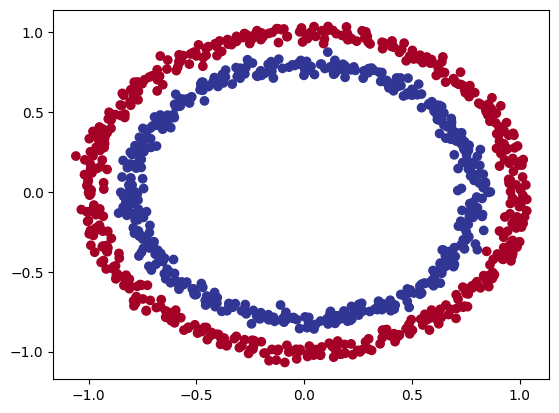

In [34]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

This dataset is also called a toy dataset. A dataset that is small but also large enough for practice

### Check input and output shape

In [35]:
X.shape

(1000, 2)

In [36]:
y.shape

(1000,)

In [37]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [38]:
X.dtype

torch.float32

In [39]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
print(f"Shape of the train data is (X_train): {X_train.shape}")
print(f"Shape of the test data is (X_test): {X_test.shape}")
print(f"Shape of the train label is (y_train): {y_train.shape}")
print(f"Shape of the test label is (y_test): {y_test.shape}")

Shape of the train data is (X_train): torch.Size([800, 2])
Shape of the test data is (X_test): torch.Size([200, 2])
Shape of the train label is (y_train): torch.Size([800])
Shape of the test label is (y_test): torch.Size([200])


## Building the model
To classify the red and blue dot

In [41]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Costruct a model that subclassing `nn.Module`

In [42]:
class CircleModuleV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create two nn.linear layers capable of hanlonh out data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 inpit features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features= 1) # output layer
    # define a forward
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x --> layer_1 --> layer-2 -->output
model_0 = CircleModuleV0()
model_0


CircleModuleV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### REeplicating above with `nn.Sequential()`

In [43]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features= 5, out_features=1)
)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [44]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2822,  0.5669],
                      [ 0.3423,  0.6544],
                      [ 0.2390, -0.2485],
                      [-0.6685, -0.6738],
                      [ 0.5786, -0.2591]])),
             ('0.bias', tensor([-0.1648,  0.1135,  0.6607, -0.6269,  0.3344])),
             ('1.weight',
              tensor([[-0.4365,  0.1206, -0.1270, -0.0619, -0.0711]])),
             ('1.bias', tensor([0.2384]))])

In [45]:
# pass data thrugh it
# make preds
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length f preictuns: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length f preictuns: 200, Shape: torch.Size([200, 1])
Length of samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Set up loss function and optimizer


In [46]:
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid activation function built in
optimizer = torch.optim.SGD(params = model_0.parameters(), lr= 0.1)


In [47]:
# Evaluation
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [48]:
# View the first 5 outputs f the forwar pass on the test data. 
# Remember our model is just instantiated with random numbers
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)
y_logits[:5]

tensor([[0.2448],
        [0.1797],
        [0.3582],
        [0.2129],
        [0.2673]])

In [49]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [50]:
# use the sigmoid activation on our logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5609],
        [0.5448],
        [0.5886],
        [0.5530],
        [0.5664],
        [0.5568],
        [0.5292],
        [0.5320],
        [0.5895],
        [0.5435],
        [0.5615],
        [0.5557],
        [0.5296],
        [0.5902],
        [0.5930],
        [0.5436],
        [0.5398],
        [0.5688],
        [0.5692],
        [0.5775],
        [0.5444],
        [0.5397],
        [0.5737],
        [0.5750],
        [0.5316],
        [0.5317],
        [0.5880],
        [0.5496],
        [0.5951],
        [0.5867],
        [0.5372],
        [0.5319],
        [0.5585],
        [0.5766],
        [0.5611],
        [0.5452],
        [0.5550],
        [0.5903],
        [0.5814],
        [0.5890],
        [0.5756],
        [0.5878],
        [0.5402],
        [0.5687],
        [0.5574],
        [0.5432],
        [0.5625],
        [0.5443],
        [0.5482],
        [0.5608],
        [0.5543],
        [0.5564],
        [0.5460],
        [0.5733],
        [0.5377],
        [0

For our probability values, we need y perform a range style rounding on them 

In [51]:
torch.round(y_preds_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [52]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# in full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test)))
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

## Training and testing loop

In [53]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred prbs -> pred labels

    # 2. loss and accuracy
    # if dealing with nn.BCElLoss, it expects prediction probabilities as input
    #loss = loss_fn(torch.sigmoid(y_logits), y_train)

    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step (gradient descent)
    optimizer.step()


    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1, forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test lss / accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

#print out whats happeninh
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss {loss:5f} | Acc : {acc:2f}% | Test loss : {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | loss 0.702949 | Acc : 50.000000% | Test loss : 0.698371 | Test Acc: 50.000000%
Epoch: 10 | loss 0.697716 | Acc : 50.000000% | Test loss : 0.694252 | Test Acc: 50.000000%
Epoch: 20 | loss 0.695685 | Acc : 56.250000% | Test loss : 0.693034 | Test Acc: 60.000000%
Epoch: 30 | loss 0.694753 | Acc : 51.750000% | Test loss : 0.692781 | Test Acc: 56.000000%
Epoch: 40 | loss 0.694243 | Acc : 51.250000% | Test loss : 0.692859 | Test Acc: 54.500000%
Epoch: 50 | loss 0.693923 | Acc : 50.875000% | Test loss : 0.693048 | Test Acc: 56.500000%
Epoch: 60 | loss 0.693706 | Acc : 50.125000% | Test loss : 0.693267 | Test Acc: 56.500000%
Epoch: 70 | loss 0.693550 | Acc : 49.750000% | Test loss : 0.693482 | Test Acc: 55.000000%
Epoch: 80 | loss 0.693437 | Acc : 50.125000% | Test loss : 0.693680 | Test Acc: 53.000000%
Epoch: 90 | loss 0.693351 | Acc : 50.625000% | Test loss : 0.693856 | Test Acc: 53.000000%
Epoch: 100 | loss 0.693286 | Acc : 51.000000% | Test loss : 0.694008 | Test Acc: 52.000000%

From the metrics it lks like our model is nt learning anything, its basically guesing

### Make visualization

In [54]:
import requests
from pathlib import Path 

# Download helper function frm Learn PyTorch repo

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print(f"Downloading helper_functions.py")

    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


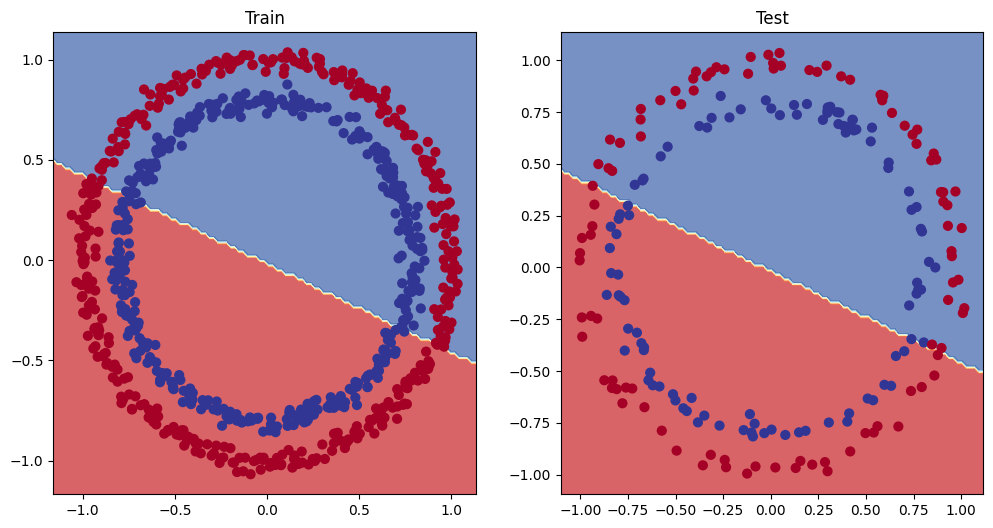

In [55]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving our model

In [56]:
class CircleModuleV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speedups where possible
model_1 = CircleModuleV1()
model_1

CircleModuleV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
# create a lss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [58]:
torch.manual_seed(42)

In [59]:
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backwras
    loss.backward()

    # 5 ptimizer step
    optimizer.step()

    ## testng
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass\
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2 calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

# 4 print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epochs} | Loss: {loss:5f} | Acc: {acc:2f}% | Test loss: {test_loss:5f} | Test acc: {test_acc:2f}%")
       




Epoch: 1000 | Loss: 0.693955 | Acc: 50.875000% | Test loss: 0.692615 | Test acc: 51.000000%
Epoch: 1000 | Loss: 0.693048 | Acc: 50.375000% | Test loss: 0.693790 | Test acc: 48.000000%
Epoch: 1000 | Loss: 0.692986 | Acc: 51.125000% | Test loss: 0.694373 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692981 | Acc: 51.625000% | Test loss: 0.694577 | Test acc: 45.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.125000% | Test loss: 0.694645 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694668 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694676 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694678 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694679 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694679 | Test acc: 46.000000%


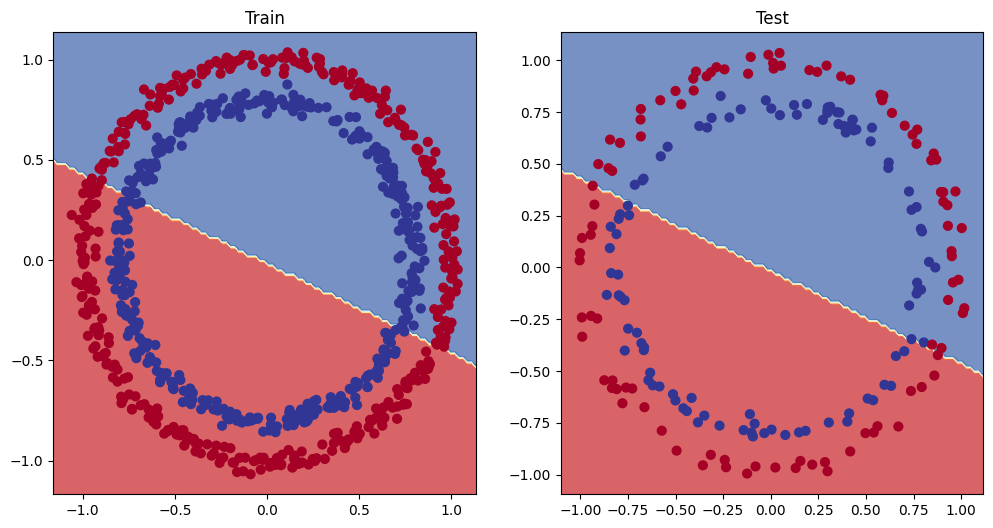

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The nn.Linear alone is not making our model learn anything. We need to combine linear and non-linear functions to get good result

### Re-creating the non-linear data

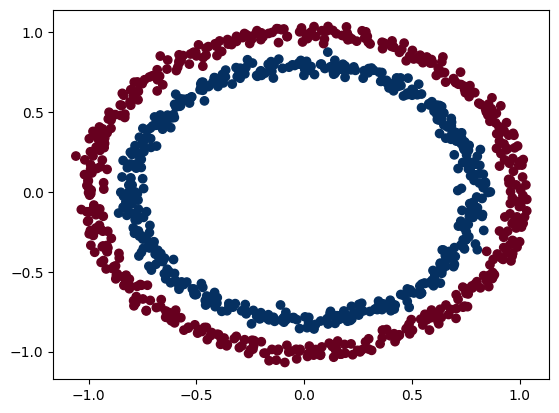

In [61]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [62]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

Building a model with non-linearity

In [64]:
class CircleModuleV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2=CircleModuleV2()
model_2

CircleModuleV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [65]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [67]:
len(X_test), len(y_test)

(200, 200)

In [69]:
torch.manual_seed(42)
EPOCHS = 1000
for epoch in range (EPOCHS):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()


    #testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:4f} | Acc: {acc:2f}% | Test loss: {test_loss:4f} | Test Acc: {test_acc}%")

Epoch: 0 | Training Loss: 0.672930 | Acc: 59.625000% | Test loss: 0.670627 | Test Acc: 59.5%
Epoch: 100 | Training Loss: 0.666526 | Acc: 61.250000% | Test loss: 0.665374 | Test Acc: 62.0%
Epoch: 200 | Training Loss: 0.655747 | Acc: 64.250000% | Test loss: 0.656949 | Test Acc: 65.0%
Epoch: 300 | Training Loss: 0.638790 | Acc: 67.500000% | Test loss: 0.643242 | Test Acc: 69.0%
Epoch: 400 | Training Loss: 0.606949 | Acc: 74.125000% | Test loss: 0.617761 | Test Acc: 74.5%
Epoch: 500 | Training Loss: 0.546866 | Acc: 90.000000% | Test loss: 0.565707 | Test Acc: 86.0%
Epoch: 600 | Training Loss: 0.447745 | Acc: 96.625000% | Test loss: 0.475181 | Test Acc: 94.5%
Epoch: 700 | Training Loss: 0.323644 | Acc: 99.000000% | Test loss: 0.355913 | Test Acc: 98.5%
Epoch: 800 | Training Loss: 0.210921 | Acc: 99.875000% | Test loss: 0.245958 | Test Acc: 99.0%
Epoch: 900 | Training Loss: 0.156271 | Acc: 99.750000% | Test loss: 0.192658 | Test Acc: 98.5%


In [70]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

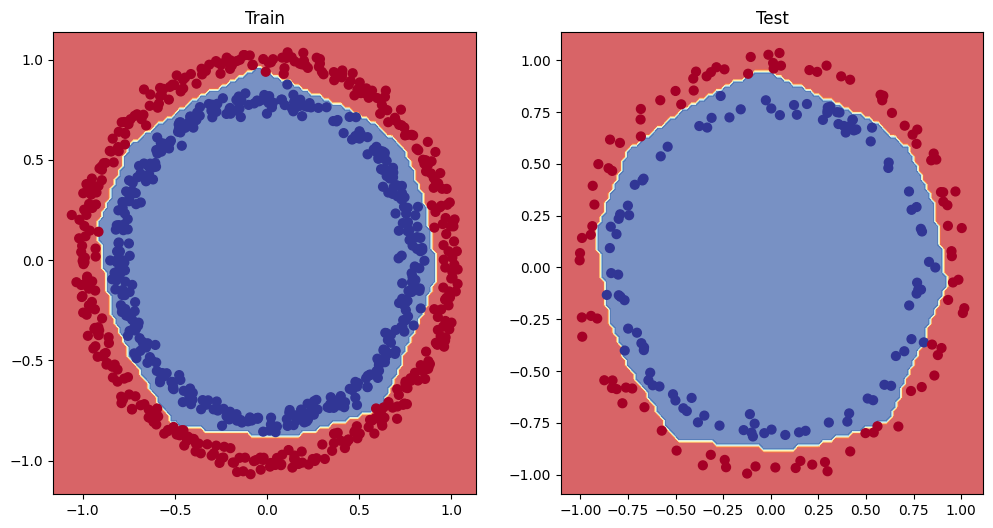

In [71]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### Replicating non-linear activation function

In [75]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

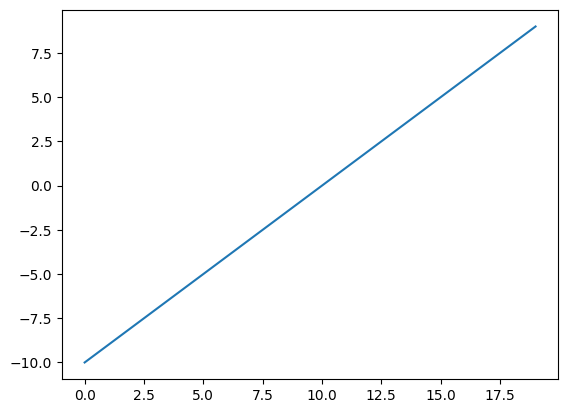

In [76]:
plt.plot(A)

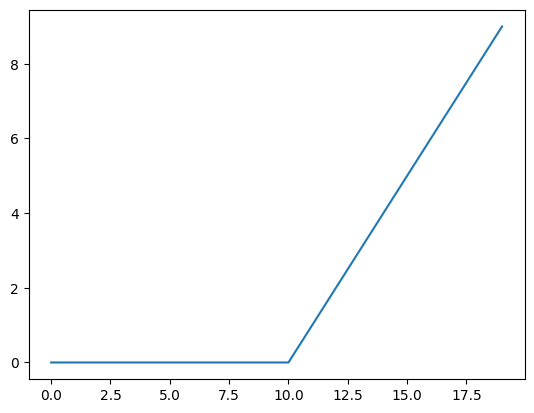

In [78]:
plt.plot(torch.relu(A))

In [79]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [80]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

Relu basically convert negative values to 0 and leaves all positive values as they are

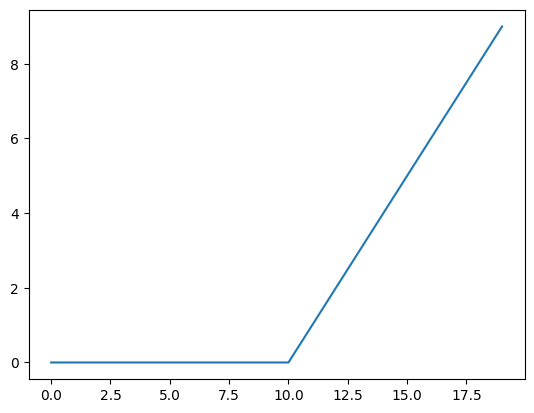

In [81]:
plt.plot(relu(A))

In [82]:
#Replicating sigmoid

def sigmoid(x):
    return 1 / (1+torch.exp(-x))

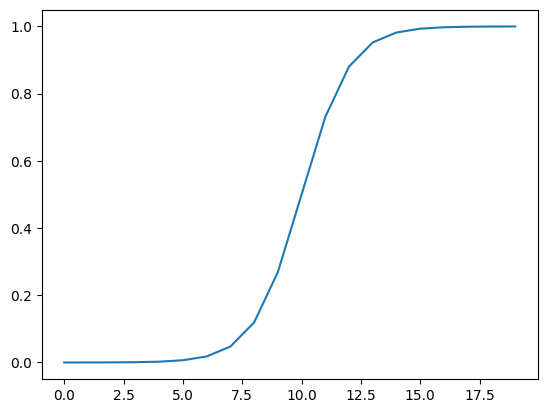

In [83]:
plt.plot(torch.sigmoid(A))

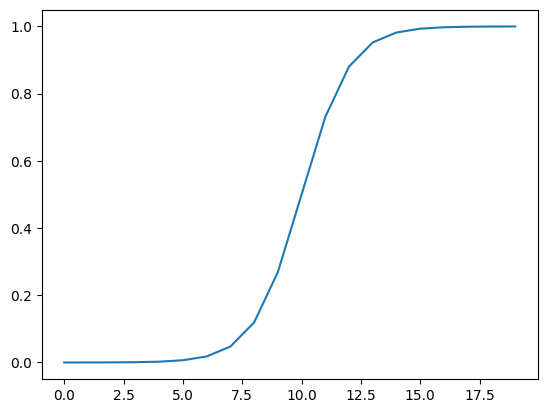

In [85]:
plt.plot(sigmoid(A))